In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets,models,layers
import os
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Loading dataset

In [3]:
data_dir = "./Alzheimer_s Dataset/train"
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
print(os.listdir(data_dir))

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


# Reading images and labels

In [4]:
def load_data(folder, num_channels=3):
    images = []
    labels = []
    
    class_to_label = {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3} 
    class_folders = os.listdir(folder)
    for class_folder in class_folders:
        class_label = class_to_label.get(class_folder)
        if class_label is None:
            continue 
        
        class_folder_path = os.path.join(folder, class_folder)
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            img = Image.open(img_path)
            if img is not None:
                img = np.array(img)
                if len(img.shape) == 2:  
                    img = np.expand_dims(img, axis=-1)
                    img = np.repeat(img, num_channels, axis=-1)
                images.append(img)
                labels.append(class_label)
    return images, labels


train_folder = "./Alzheimer_s Dataset/train"
test_folder = "./Alzheimer_s Dataset/test"

train_images, train_labels = load_data(train_folder)
test_images, test_labels = load_data(test_folder)

In [5]:
print(len(train_images))
print(len(test_images))

5121
1279


# Converting images into np array 

In [6]:
train_images = np.array(train_images)
test_images = np.array(test_images)
train_images, test_images = train_images / 255.0, test_images / 255.0

In [7]:
print(train_images.shape)
print(test_images.shape)

(5121, 208, 176, 3)
(1279, 208, 176, 3)


# Generating more train images

In [8]:
image_generator = ImageDataGenerator(brightness_range=[0.8, 1.2], zoom_range=[0.99, 1.01], horizontal_flip=True, fill_mode="constant", data_format="channels_last")

In [9]:
train_data_gen = image_generator.flow_from_directory(directory=data_dir, target_size=(176, 176), batch_size=6500, shuffle=False)

Found 5121 images belonging to 4 classes.


# Displaying read images

In [10]:
import random

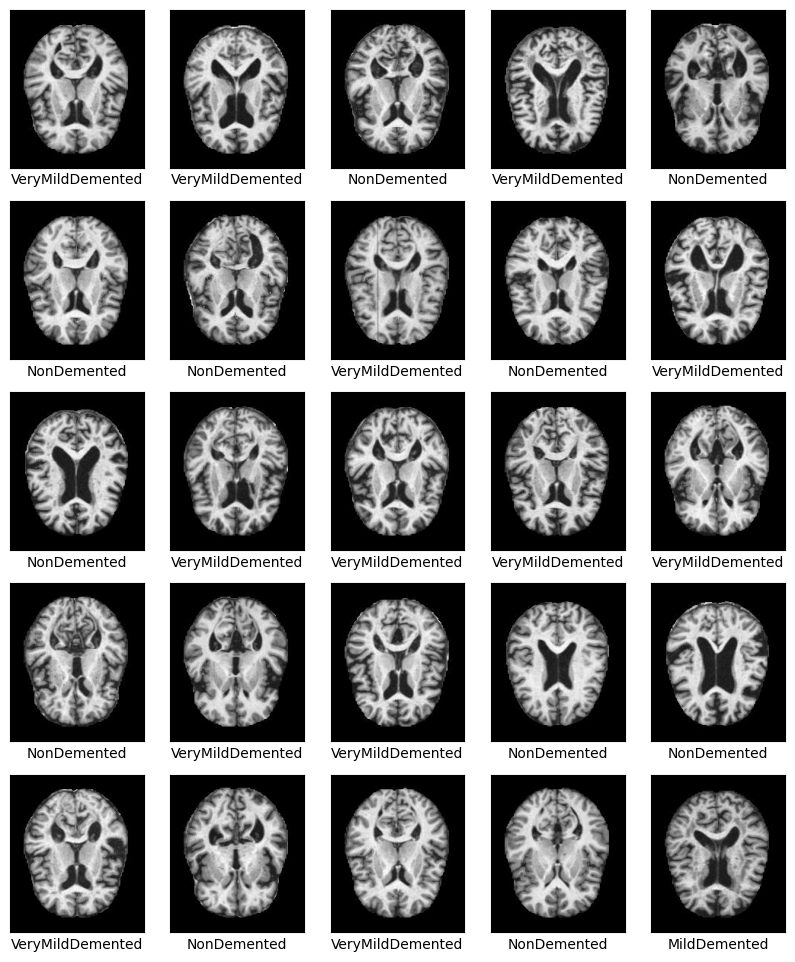

In [10]:
label_names = {0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3:'VeryMildDemented'}
random_indices = random.sample(range(len(train_images)), 25)

plt.figure(figsize=(10, 12))  
for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[idx])
    label_name = label_names[train_labels[idx]]
    plt.xlabel(label_name)
 
plt.show()

In [10]:
train_images, train_labels = train_data_gen.next()
print(train_images.shape, train_labels.shape)

(5121, 176, 176, 3) (5121, 4)


In [11]:
for alzheimers_class in classes:
    container = []
    temp_dir = data_dir + "/" + alzheimers_class
    for file in os.listdir(temp_dir):
        container.append(file)
    print(alzheimers_class, ": ", len(container))

MildDemented :  717
ModerateDemented :  52
NonDemented :  2560
VeryMildDemented :  1792


# Resampling train images

In [12]:
import imblearn

In [13]:
sm = imblearn.over_sampling.SMOTE(random_state=42)
train_images, train_labels = sm.fit_resample(train_images.reshape(-1, 176 * 176 * 3), train_labels)
train_images = train_images.reshape(-1, 176, 176, 3)
print(train_images.shape, train_labels.shape)

(10240, 176, 176, 3) (10240, 4)


# Creating blocks of cnn model

In [15]:
def conv_block(filters, act='relu'):    
    block = models.Sequential()
    block.add(layers.Conv2D(filters, 3, activation=act, padding='same'))
    block.add(layers.Conv2D(filters, 3, activation=act, padding='same'))
    block.add(layers.BatchNormalization())
    block.add(layers.MaxPool2D())
    
    return block

In [16]:
def norm_block(units, dropout_rate, act='relu'):    
    block = models.Sequential()
    block.add(layers.Dense(units, activation=act))
    block.add(layers.BatchNormalization())
    block.add(layers.Dropout(dropout_rate))
    
    return block

# Constructing Model with layers

In [17]:
def construct_model(act='relu'):
    model = models.Sequential([
        tf.keras.Input(shape=(*[176, 176], 3)),
        layers.Conv2D(16, 3, activation=act, padding='same'),
        layers.Conv2D(16, 3, activation=act, padding='same'),
        layers.MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        layers.Dropout(0.2),
        conv_block(256),
        layers.Dropout(0.2),
        layers.Flatten(),
        norm_block(512, 0.7),
        norm_block(128, 0.5),
        norm_block(64, 0.3),
        layers.Dense(4, activation='softmax') 
    ], name = "cnn_model")

    return model

In [26]:
model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 16)        0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                         

# Training model 

In [27]:
history = model.fit(train_images, train_labels, epochs=100, validation_split=0.2)

Epoch 1/100

256/256 [==============================] - 238s 885ms/step - loss: 1.6138 - acc: 0.3213 - auc: 0.5882 - val_loss: 1.0074 - val_acc: 0.6235 - val_auc: 0.8186
Epoch 2/100
256/256 [==============================] - 229s 893ms/step - loss: 1.1937 - acc: 0.4679 - auc: 0.7393 - val_loss: 0.9974 - val_acc: 0.6260 - val_auc: 0.8684
Epoch 3/100
256/256 [==============================] - 224s 875ms/step - loss: 0.9356 - acc: 0.5916 - auc: 0.8398 - val_loss: 1.0014 - val_acc: 0.4326 - val_auc: 0.8130
Epoch 4/100
256/256 [==============================] - 225s 880ms/step - loss: 0.8067 - acc: 0.6432 - auc: 0.8805 - val_loss: 2.3912 - val_acc: 0.0400 - val_auc: 0.5031
Epoch 5/100
256/256 [==============================] - 227s 886ms/step - loss: 0.7236 - acc: 0.6759 - auc: 0.9042 - val_loss: 3.7857 - val_acc: 0.0073 - val_auc: 0.3504
Epoch 6/100
256/256 [==============================] - 224s 876ms/step - loss: 0.6633 - acc: 0.7013 - auc: 0.9204 - val_loss: 3.8987 - val_acc: 0.0176 - v

Epoch 48/100
256/256 [==============================] - 161s 628ms/step - loss: 0.0444 - acc: 0.9863 - auc: 0.9989 - val_loss: 0.3973 - val_acc: 0.8921 - val_auc: 0.9789
Epoch 49/100
256/256 [==============================] - 162s 631ms/step - loss: 0.0397 - acc: 0.9878 - auc: 0.9990 - val_loss: 0.2251 - val_acc: 0.9355 - val_auc: 0.9912
Epoch 50/100
256/256 [==============================] - 162s 633ms/step - loss: 0.0423 - acc: 0.9861 - auc: 0.9993 - val_loss: 0.8657 - val_acc: 0.7593 - val_auc: 0.9493
Epoch 51/100
256/256 [==============================] - 162s 635ms/step - loss: 0.0714 - acc: 0.9786 - auc: 0.9978 - val_loss: 0.0069 - val_acc: 0.9980 - val_auc: 1.0000
Epoch 52/100
256/256 [==============================] - 162s 631ms/step - loss: 0.0452 - acc: 0.9863 - auc: 0.9992 - val_loss: 0.0295 - val_acc: 0.9897 - val_auc: 0.9996
Epoch 53/100
256/256 [==============================] - 161s 630ms/step - loss: 0.0371 - acc: 0.9884 - auc: 0.9993 - val_loss: 0.0926 - val_acc: 0.968

In [154]:
model.save('CNNModel.keras')

In [14]:
cnn_model = models.load_model('CNNModel.keras')
cnn_model.summary()




Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 16)        0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                      

In [29]:
import pickle

In [155]:
with open('cnntraining_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

history_df = pd.DataFrame(history.history)
history_df.to_csv('cnntraining_history.csv', index=False)

In [25]:
#with open('cnntraining_history.pkl', 'rb') as file:
    #history = pickle.load(file)

#history_df = pd.read_csv('cnntraining_history.csv')

# Convert the DataFrame back to a dictionary
#history = history_df.to_dict(orient='list')

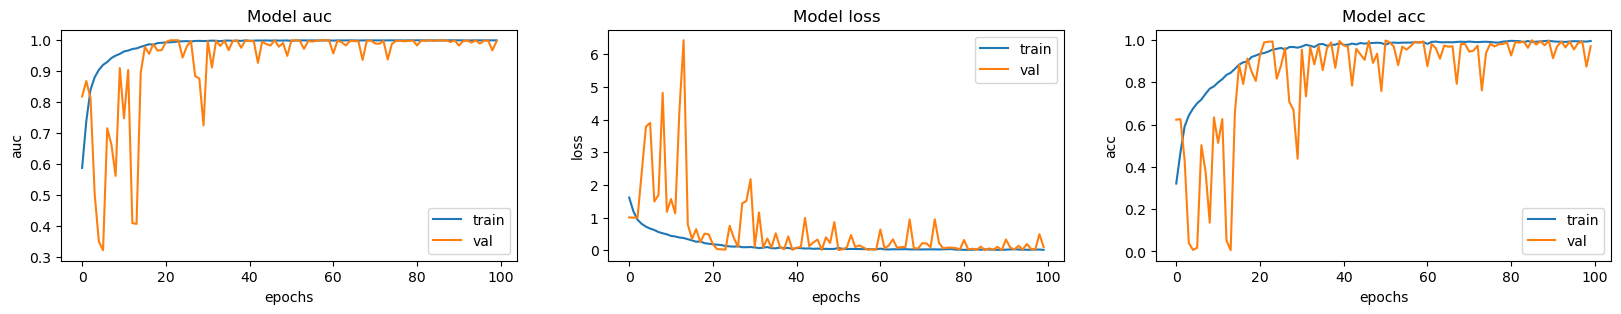

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss', 'acc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Testing model 

In [15]:
data_dir1 = "./Alzheimer_s Dataset/test"
data_dir1

'./Alzheimer_s Dataset/test'

In [16]:
test_data_gen = image_generator.flow_from_directory(directory=data_dir1, target_size=(176, 176), batch_size=4096, shuffle=False)

Found 1279 images belonging to 4 classes.


In [17]:
test_data_gen1 = image_generator.flow_from_directory(directory=data_dir1, target_size=(176, 176), batch_size=16, shuffle=False)

Found 1279 images belonging to 4 classes.


In [18]:
test_images, test_labels = test_data_gen1.next()
print(test_images.shape, test_labels.shape)

(16, 176, 176, 3) (16, 4)


In [158]:
test_scores1 = model.evaluate(test_images, test_labels)
test_scores1

1/1 [==============================] - 0s 248ms/step - loss: 0.0602 - acc: 0.9375 - auc: 0.9987


[0.06018202006816864, 0.9375, 0.9986978769302368]

In [20]:
predicted_test_labels = cnn_model.predict(test_images)

1/1 [==============================] - 1s 1s/step


In [148]:
test_images, test_labels = test_data_gen.next()
print(test_images.shape, test_labels.shape)

(1279, 176, 176, 3) (1279, 4)


In [150]:
predicted_test_labels = model.predict(test_images)

40/40 [==============================] - 11s 264ms/step


# Model evaluation

In [21]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in predicted_test_labels:
    labels = roundoff(labels)

In [23]:
print(classification_report(test_labels, predicted_test_labels, target_names=classes,zero_division=1))

                  precision    recall  f1-score   support

    MildDemented       1.00      0.81      0.90        16
ModerateDemented       1.00      1.00      1.00         0
     NonDemented       0.00      1.00      0.00         0
VeryMildDemented       0.00      1.00      0.00         0

       micro avg       0.81      0.81      0.81        16
       macro avg       0.50      0.95      0.47        16
    weighted avg       1.00      0.81      0.90        16
     samples avg       0.81      0.81      0.81        16



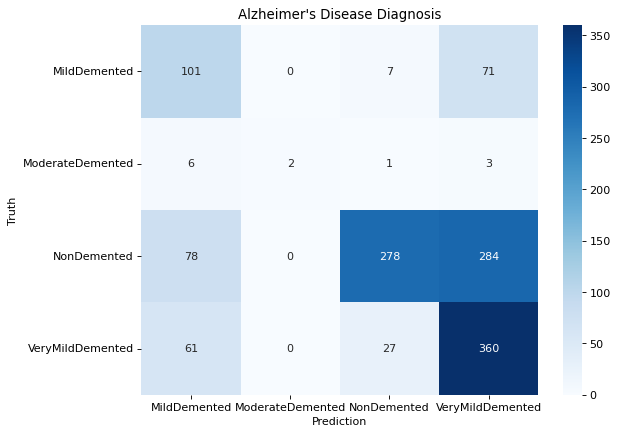

In [153]:
pred_ls = np.argmax(predicted_test_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)